# An initial training pipeline

In [1]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
import dask.dataframe as dd
import pandas as pd
import numpy as np

from glob import glob
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(ft_dir+'/*.parquet')
df = dd.read_parquet(ft_glob).compute().reset_index().dropna()


In [ ]:
cat_file = os.path.join(
    os.getenv("PRICE_CSV_DATA"), 
    'symbols_valid_meta.csv'
)
cat_df = (pd.read_csv(cat_file)
          .rename(columns = {'Symbol': 'ticker'})[['ticker', 'Listing Exchange', 'Market Category']]
          )
df = df.merge(cat_df, on = 'ticker', how = 'left') # merge command is a SQL operation

In [3]:
df

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,Close_lag_1,Listing Exchange,Market Category
0,A,2014-07-07,41.630901,41.666668,41.380543,41.573677,39.293072,1326900.0,A.csv,2014,41.816883,N,
1,A,2014-07-08,41.373390,41.437767,40.715309,40.879829,38.637295,2259000.0,A.csv,2014,41.573677,N,
2,A,2014-07-09,40.808296,40.829758,40.429184,40.701000,38.468281,1787300.0,A.csv,2014,40.879829,N,
3,A,2014-07-10,40.350502,40.507870,40.064377,40.407726,38.191090,1662600.0,A.csv,2014,40.701000,N,
4,A,2014-07-11,40.293278,40.586552,40.164520,40.486408,38.265457,1654200.0,A.csv,2014,40.407726,N,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
324196,ZEUS,2004-12-27,28.000000,29.230000,27.690001,28.670000,26.258089,651600.0,ZEUS.csv,2004,27.670000,Q,Q
324197,ZEUS,2004-12-28,28.900000,30.200001,28.700001,29.900000,27.384602,529400.0,ZEUS.csv,2004,28.670000,Q,Q
324198,ZEUS,2004-12-29,30.280001,30.299999,29.030001,29.070000,26.624434,355300.0,ZEUS.csv,2004,29.900000,Q,Q
324199,ZEUS,2004-12-30,28.450001,28.450001,25.330000,26.170000,23.968391,1361800.0,ZEUS.csv,2004,29.070000,Q,Q


## Preprocessing

+ Previously, we produced a features data set.
+ Most times, one or more [preprocessing steps](https://scikit-learn.org/stable/modules/preprocessing.html#) steps will be applied to data.
+ The most practical way to apply them is by arranging them in `Pipeline` objects, wchich are sequential transformations applied to data. 
+ It is convenient for us to label these transformations and there is a standard way of doing so.


## Transformations

+ Transformations are classes that implement `fit` and `transform` methods.

### StandardScaler

+ For example, transform a numerical variable by standardizing it.
- Standardization is removing the mean value of the feature and scale it by dividing non-constant features by their standard deviation.

$$
z = \frac{x-\mu}{\sigma}
$$


+  Using [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), one can do the following:

In [4]:
df.columns

Index(['ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'source', 'Year', 'Close_lag_1', 'Listing Exchange', 'Market Category'],
      dtype='object')

In [5]:
df = (df.assign(
        returns = lambda x: x['Close']/x['Close_lag_1'] - 1, 
        positive_return = lambda x: 1.0*(x['returns'] > 0),
        hi_lo = lambda x: x['High'] - x['Low'],
        op_cl = lambda x: x['Close'] - x['Open']
    ).groupby(['ticker'], group_keys=False).apply(
        lambda x: x.assign(target = x['positive_return'].shift(-1))
    )
    .reset_index(drop=True)
    .dropna(subset = ['target'])
    )
df

/var/folders/s7/1h5812v56198slm5x05gnjl00000gn/T/ipykernel_72337/619560177.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).groupby(['ticker'], group_keys=False).apply(


,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,Close_lag_1,Listing Exchange,Market Category,returns,positive_return,hi_lo,op_cl,target
0,A,2014-07-07,41.630901,41.666668,41.380543,41.573677,39.293072,1326900.0,A.csv,2014,41.816883,N,,-0.005816,0.0,0.286125,-0.057224,0.0
1,A,2014-07-08,41.373390,41.437767,40.715309,40.879829,38.637295,2259000.0,A.csv,2014,41.573677,N,,-0.016690,0.0,0.722458,-0.493561,0.0
2,A,2014-07-09,40.808296,40.829758,40.429184,40.701000,38.468281,1787300.0,A.csv,2014,40.879829,N,,-0.004375,0.0,0.400574,-0.107296,0.0
3,A,2014-07-10,40.350502,40.507870,40.064377,40.407726,38.191090,1662600.0,A.csv,2014,40.701000,N,,-0.007206,0.0,0.443493,0.057224,1.0
4,A,2014-07-11,40.293278,40.586552,40.164520,40.486408,38.265457,1654200.0,A.csv,2014,40.407726,N,,0.001947,1.0,0.422031,0.193130,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324195,ZEUS,2004-12-23,28.010000,28.100000,27.360001,27.670000,25.342215,109200.0,ZEUS.csv,2004,27.719999,Q,Q,-0.001804,0.0,0.740000,-0.340000,1.0
324196,ZEUS,2004-12-27,28.000000,29.230000,27.690001,28.670000,26.258089,651600.0,ZEUS.csv,2004,27.670000,Q,Q,0.036140,1.0,1.539999,0.670000,1.0
324197,ZEUS,2004-12-28,28.900000,30.200001,28.700001,29.900000,27.384602,529400.0,ZEUS.csv,2004,28.670000,Q,Q,0.042902,1.0,1.500000,1.000000,0.0
324198,ZEUS,2004-12-29,30.280001,30.299999,29.030001,29.070000,26.624434,355300.0,ZEUS.csv,2004,29.900000,Q,Q,-0.027759,0.0,1.269999,-1.210001,0.0


In [10]:
returns = df.returns.values.reshape(-1,1)

In [11]:
# Create a StandardScaler object

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()


# Fit the StandardScaler object with the returns data
std_scaler.fit(returns)

,copy,True
,with_mean,True
,with_std,True


In [13]:
# Transform the returns data using the fitted scaler

scaled_returns_np = std_scaler.transform(returns)
scaled_returns = pd.DataFrame(scaled_returns_np, columns=['returns'])
scaled_returns.describe()

,returns
count,3.241130e+05
mean,6.247965e-19
std,1.000002e+00
min,-6.209999e-03
25%,-2.469430e-03
50%,-2.430103e-03
75%,-2.391593e-03
max,5.634915e+02


In [14]:
df.returns.describe()

count    324113.000000
mean          0.642824
std         264.525666
min          -0.999878
25%          -0.010403
50%           0.000000
75%           0.010187
max      149058.378332
Name: returns, dtype: float64

###  OneHotEncoder

+ Categorical features can be encoded as numerical values using `OneHotEncoder`.

<Axes: xlabel='Listing Exchange'>

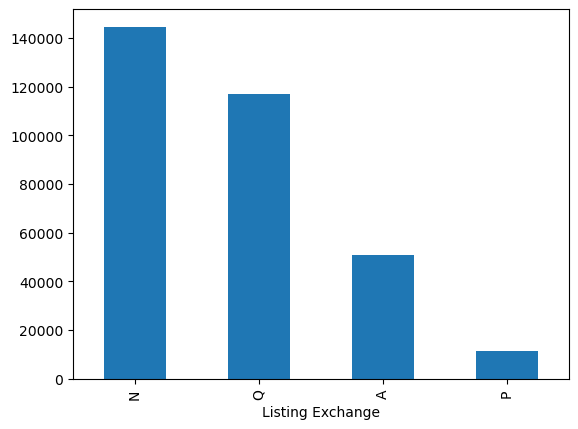

In [15]:
df['Listing Exchange'].value_counts().plot(kind = 'bar')

+ Use [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode a categorical variable as numerical.
+ Important parameters:

    - `categories` allows you to specify the categories to work with.
    - `drop`: we can drop the `'first'` value (dummy encoding) or `'if_binary'`, a convenience setting for binary values.
    - `handle_unknown` allows three options, `'error'`, `'ignore'`, and `'infrequent_if_exist'`, depending on what we want to do with new values.

In [16]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
onehot.fit(df[['Listing Exchange']])

,categories,'auto'
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [17]:
listing_enc = onehot.transform(df[['Listing Exchange']])
listing_enc.toarray()

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], shape=(324113, 4))

In [18]:
listing_enc

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 324113 stored elements and shape (324113, 4)>

# Pipelines

+ It is impractical and costly to manipulate data "by hand". 
+ To manage data preprocessing steps within the cross-validation process use `Pipeline` objects.
+ A [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object allows us to sequentially apply transformation steps and, if required, a predictor.
+ `Pipeline` objects compose transforms, i.e., classes that implement `transform` and `fit` methods.
+ The purpose of `Pipeline` objects is to ensemble transforms and predictors to be used in cross-validation.
+ A `Pipeline` is defined by a list of tuples.
+ Each tuple is composed of `("name", <ColumnTransformer>)`, the name of the step and the `<ColumnTransformer>` function of our chosing.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score


In [20]:
pipe1 = Pipeline(
    [
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('knn', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))

    ]
)
pipe1

,steps,"[('onehot', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [21]:
X0 = df[['Listing Exchange', 'Market Category']]
Y0 = df['target']
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.2, random_state=42)

pipe1.fit(X0_train, Y0_train)

,steps,"[('onehot', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [22]:
Y_pred_train = pipe1.predict(X0_train)
Y_pred_test = pipe1.predict(X0_test)

In [23]:
Y_poba_train = pipe1.predict_proba(X0_train)
Y_proba_test = pipe1.predict_proba(X0_test)

In [25]:
Y_poba_train

array([[0.53348403, 0.46651597],
       [0.63879705, 0.36120295],
       [0.53348403, 0.46651597],
       ...,
       [0.53348403, 0.46651597],
       [0.63879705, 0.36120295],
       [0.53348403, 0.46651597]], shape=(259290, 2))

In [24]:
res = {
    'accuracy_score_train': accuracy_score(Y0_train, Y_pred_train),
    'accuracy_score_test': accuracy_score(Y0_test, Y_pred_test),
    'cohen_kappa_train': cohen_kappa_score(Y0_train, Y_pred_train),
    'cohen_kappa_test': cohen_kappa_score(Y0_test, Y_pred_test),
    'log_loss_train': log_loss(Y0_train, Y_poba_train),
    'log_loss_test': log_loss(Y0_test, Y_proba_test),
    'f1_score_train': f1_score(Y0_train, Y_pred_train),
    'f1_score_test': f1_score(Y0_test, Y_pred_test)
}
res

{'accuracy_score_train': 0.565085425585252,
 'accuracy_score_test': 0.5603875167764528,
 'cohen_kappa_train': 0.0,
 'cohen_kappa_test': 0.0,
 'log_loss_train': 0.6806518440753812,
 'log_loss_test': 0.6818831559716808,
 'f1_score_train': 0.0,
 'f1_score_test': 0.0}

+ The model does not show great performance, but the pipeline shows results. 
+ Below, we expand the pipeline to include more variables, and further we will work with more robust model selection pipelines.

## ColumnTransformer

+ Use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply transformers to specific columns of a DataFrame.
+ In this case, we will scale numeric variables and apply one-hot encoding to categorical columns.

In [26]:
from sklearn.compose import ColumnTransformer

In [27]:
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), ['returns', 'Volume', 'op_cl', 'hi_lo'] ),
        ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['Listing Exchange', 'Market Category']), 
    ], remainder='drop'
)

pipe = Pipeline(
    [
        ('preproc', transformer), 
        ('decisiontree', DecisionTreeClassifier(criterion = 'entropy', max_depth=3))
    ]
)

In [30]:
pipe

,steps,"[('preproc', ...), ('decisiontree', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric_transfomer', ...), ('onehot', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Model Selection

The model selection process is an iterative process in which :

+ Select schema and load data.
+ Define a pipeline and its (hyper) parameters.

    - Use ColumnTransformers to transform numeric and cateogrical variables.
    - Hyperparameters can be defined independently of code. 

+ Implement a splitting strategy. 

    - Use [cross_validate]() to select several metrics and operational details.

+ Measure performance.

    - [Select metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

+ Repeat

## Training, Validation, Testing Split

+ The first spliting strategy is to use a training, validation, and test set.
+ Training set will be used to fit the model.
+ Validation set is used to evaluate hyperparameter choice.
+ Testing set is used to evaluate performance on data the model has not yet seen.
+ In this case we want to compare two models: 

    - Decision Tree with 3 minumum samples per leaf.
    - Decision Tree with 10 minimum samples per leaf.

![](./images/03b_train_validate_test.png)

## Setting parameters in pipeline steps

+ One can obtain the parameters of a pipeline with `pipe.get_params()`.
+ We can set any parameter of a pipeline with `pipe.set_parames(**kwargs)`. 
+ The input `**kwargs` is a dictionary of the params to be modified. Params of the steps are labeled with the name of the step followed by `__` and the name of the parameter.

+ There are a few steps that we will repeat: 

    - Fit the candidate model on training data.
    - Predict on training and test data.
    - Compute training and test performance metrics.
    - Return.

+ We encapsulate this procedure in a function. 

In [31]:
def evaluate_model(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)
    Y_pred_train = clf.predict(X_train)
    Y_pred_test = clf.predict(X_test)
    Y_proba_train = clf.predict_proba(X_train)
    Y_proba_test = clf.predict_proba(X_test)
    performance_metrics = {
        'log_loss_train': log_loss(Y_train, Y_proba_train),
        'log_loss_test': log_loss(Y_test, Y_proba_test),
        'cohen_kappa_train': cohen_kappa_score(Y_train, Y_pred_train),
        'cohen_kappa_test': cohen_kappa_score(Y_test, Y_pred_test),
        'f1_score_train': f1_score(Y_train, Y_pred_train),
        'f1_score_test': f1_score(Y_test, Y_pred_test),
        'accuracy_score_train': accuracy_score(Y_train, Y_pred_train),
        'accuracy_score_test': accuracy_score(Y_test, Y_pred_test),
    }
    return performance_metrics

In [32]:
# Schema
X = df[['returns', 'op_cl', 'hi_lo', 'Volume', 'Listing Exchange', 'Market Category']]
Y = df['target']

# Split the data
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_validate, Y_train,  Y_validate = train_test_split(X_rest, Y_rest, test_size=0.2, random_state=42)


In [33]:
# Evaluate hyperparameter configuration 2
pipe_d3 = pipe.set_params(**{'decisiontree__max_depth': 3})
res_d3 = evaluate_model(pipe_d3, X_train, Y_train, X_validate, Y_validate)
res_d3

{'log_loss_train': 0.6693617968709523,
 'log_loss_test': 0.6690770856125402,
 'cohen_kappa_train': 0.0012713435692601749,
 'cohen_kappa_test': 0.0005148981766118776,
 'f1_score_train': 0.003029967930996351,
 'f1_score_test': 0.0018619497273573613,
 'accuracy_score_train': 0.5653708203170196,
 'accuracy_score_test': 0.5658336225847507}

In [ ]:
# Get all the parameters from the pipeline
pipe.get_params()

{'memory': None,
 'steps': [('preproc',
   ColumnTransformer(transformers=[('numeric_transfomer', StandardScaler(),
                                    ['returns', 'Volume', 'op_cl', 'hi_lo']),
                                   ('onehot',
                                    OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                    ['Listing Exchange', 'Market Category'])])),
  ('decisiontree', DecisionTreeClassifier(criterion='entropy', max_depth=15))],
 'transform_input': None,
 'verbose': False,
 'preproc': ColumnTransformer(transformers=[('numeric_transfomer', StandardScaler(),
                                  ['returns', 'Volume', 'op_cl', 'hi_lo']),
                                 ('onehot',
                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                  ['Listing Exchange', 'Market Category'])]),
 'decisiontree': DecisionTreeClassifier(criterion='entropy', max_depth=15),
 'preproc__force_in

In [ ]:
# Evaluate hyperparameter configuration 2
# ** is a syntax in python that converts a dictionary to key = value
pipe_d15 = pipe.set_params(**{'decisiontree__max_depth':15})
res_d15 = evaluate_model(pipe_d15, X_train, Y_train, X_validate, Y_validate)
res_d15

{'log_loss_train': 0.6229924410383937,
 'log_loss_test': 1.4709698730107743,
 'cohen_kappa_train': 0.1546713907317654,
 'cohen_kappa_test': 0.06678142496325223,
 'f1_score_train': 0.42961225679313886,
 'f1_score_test': 0.37190242821939806,
 'accuracy_score_train': 0.6037159165413244,
 'accuracy_score_test': 0.5625554398549886}

## Cross-Validation

+ Cross-validation is a resampling method.
+ It is an iterative method applied to training data.
+ Training data is divided into folds.
+ Each fold is used once as a validation set and the rest of the folds are used for training.
+ Test data is used for final evaluation.

From [Scikit's Documentation ](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance), the diagram below shows the data divisions and folds during the cross-validation process.

![](./images/03b_grid_search_cross_validation.png)

There are two functions that can be used for [calculating cross-validation performance scores](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance): `cross_val_score()` and `cross_validate()`. The first function, [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), is a convenience function to get quick perfromance calculations. We will discuss `cross_validate()` as it offers advantages over `cross_val_score()`.

## Obtaining metrics

+ Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to measure one or more performance metrics and operational details.
+ There are two advantages of using this function. From [Scikit's documentation](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation):

>- It allows specifying multiple metrics for evaluation.
>- It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.


In [36]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'neg_log_loss', 'neg_brier_score']
d3_dict = cross_validate(pipe_d3, X, Y, cv=5, scoring = scoring, return_train_score = True)

In DataFrame form:

In [37]:
pd.DataFrame(d3_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,1.962179,0.116470,0.529210,0.605160,0.512430,0.512490,0.467020,0.554826,0.567621,0.476158,0.539037,0.660359,-2.458707,-0.621474,-0.272889,-0.220357
1,2.088121,0.108703,0.563673,0.602206,0.364376,0.469877,0.499046,0.560507,0.286943,0.404476,0.580315,0.652011,-1.578126,-0.627321,-0.252065,-0.222727
2,1.884827,0.107720,0.519738,0.612793,0.371325,0.478439,0.432333,0.579342,0.325405,0.407470,0.521369,0.668963,-1.454431,-0.618773,-0.262753,-0.219041
3,1.986071,0.127179,0.549104,0.598945,0.306670,0.416062,0.464936,0.569332,0.228790,0.327812,0.558944,0.645729,-2.117350,-0.630418,-0.264538,-0.223928
4,1.956752,0.110244,0.553408,0.604911,0.404721,0.469644,0.482923,0.565942,0.348317,0.401352,0.560444,0.658193,-2.158102,-0.622909,-0.264010,-0.221010


In [38]:
d15_dict = cross_validate(pipe_d15, X, Y, cv=5, scoring = scoring, return_train_score = True)
pd.DataFrame(d15_dict)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,test_neg_brier_score,train_neg_brier_score
0,2.219724,0.193508,0.527267,0.605149,0.512845,0.512474,0.465499,0.554811,0.570913,0.476140,0.536690,0.660340,-2.456535,-0.621492,-0.273966,-0.220359
1,2.161908,0.119391,0.563519,0.602198,0.364265,0.469752,0.498739,0.560526,0.286908,0.404281,0.579943,0.652008,-1.584221,-0.627300,-0.252231,-0.222718
2,1.928964,0.134090,0.519815,0.612816,0.371819,0.479065,0.432549,0.579161,0.326042,0.408470,0.521516,0.669005,-1.457638,-0.618736,-0.262777,-0.219026
3,2.041556,0.116243,0.549227,0.598949,0.306729,0.416143,0.465203,0.569315,0.228790,0.327918,0.559382,0.645763,-2.100950,-0.630427,-0.264199,-0.223926
4,2.005389,0.121167,0.553500,0.604911,0.404820,0.469617,0.483068,0.565950,0.348388,0.401308,0.560235,0.658169,-2.134059,-0.622939,-0.263682,-0.221020


# About Performance

+ Notice that in order to acquire information about our model and continue development, we are spending resources: time, electricity, equipment use, etc. As well, we are generating data and binary objects that implement our models (fitted `Pipeline` objects, for example).
+ For certain applications, operating performance (latency or `'score_time'`) may be as important or more important than predictive performance metrics. 
+ Every experiment throws important information and we can log them, as well as run them systematically.

In [39]:
pd.DataFrame(d15_dict).mean()

fit_time                 2.071508
score_time               0.136880
test_accuracy            0.542666
train_accuracy           0.604805
test_f1                  0.392096
train_f1                 0.469410
test_precision           0.469012
train_precision          0.565953
test_recall              0.352208
train_recall             0.403623
test_roc_auc             0.551553
train_roc_auc            0.657057
test_neg_log_loss       -1.946681
train_neg_log_loss      -0.624179
test_neg_brier_score    -0.263371
train_neg_brier_score   -0.221410
dtype: float64